In [1]:
from compute_metrics import *

# Example

## Loading data

In [2]:
h5_dir = r'C:\Users\smerino.C084288\Documents\simulatedCystDataset\downs800_0.0Att\raw'
simu_id = 5
simu_name = f'simu{simu_id:05d}'
P = LoadDataParams(h5_dir=h5_dir, simu_name=simu_name)
P.grid_zlims

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:\Users\smerino.C084288\Documents\simulatedCystDataset\downs800_0.0Att\raw\simus_00001-01000.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Beamforming

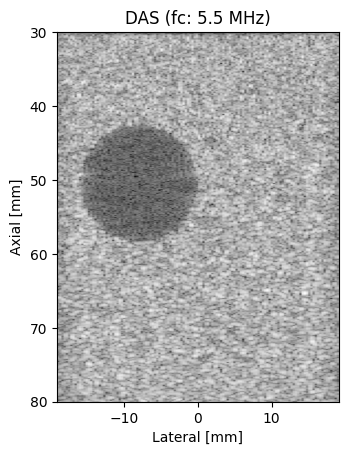

In [11]:
depths = np.linspace(P.grid_zlims[0], P.grid_zlims[1], num=800)
laterals = np.linspace(P.grid_xlims[0], P.grid_xlims[1], num=128)
grid = make_pixel_grid_from_pos(x_pos=laterals, z_pos=depths)
bmode_DAS, _ = make_bimg_das1(copy.deepcopy(P), grid, device='cpu')


extent = [laterals[0] * 1e3, laterals[-1] * 1e3, depths[-1] * 1e3, depths[0] * 1e3]
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
ax.imshow(bmode_DAS, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
ax.set_xlabel('Lateral [mm]')
ax.set_ylabel('Axial [mm]')
ax.set_title('DAS (fc: %.1f MHz)' % (P.fc/1e6))
plt.show()

## Computing metrics

In [12]:
from metrics import  compute_metrics

In [13]:
P = LoadDataParams(h5_dir=h5_dir, simu_name=simu_name)
contrast_img, cnr_img, snr_img, gcnr_img = compute_metrics(P.pos_lat,P.pos_ax,P.radius, bmode_DAS, grid)
print(contrast_img, cnr_img, snr_img, gcnr_img)

-16.882545948028564 -1.2732946 0.8629634239643112 1.4957354


# Metrics for testing set

## Params in testing set

In [4]:
import os
testing_folder = r'C:\Users\u_imagenes\Documents\smerino\testing\input'
input_file_list = sorted(os.listdir(testing_folder))
print(input_file_list[-1][:-4])
int(input_file_list[-1][-9:-4])

simu12496


12496

In [24]:
import pandas as pd
import pickle
P = LoadDataParams(h5_dir=h5_dir, simu_name=f'simu00001')
with open("common_params.pkl", "wb") as f:
    pickle.dump(P, f)

In [31]:
r = []
cx = []
cz = []
c = []
ids = []
for file in input_file_list:
    P = LoadDataParams(h5_dir=h5_dir, simu_name=file[:-4])
    r.append(P.radius)
    c.append(P.c)
    cx.append(P.pos_lat)
    cz.append(P.pos_ax)
    ids.append(int(file[-9:-4]))
dataset_params = {"id": ids, "r": r, "cx": cx, "cz": cz, "c": c}
params_df = pd.DataFrame(dataset_params)
params_df.to_csv('dataset_params.csv')

In [32]:
params_df.head()

,id,r,cx,cz,c
0,14,0.008,-0.006,0.0550,1420.0
1,15,0.006,-0.008,0.0575,1570.0
2,16,0.006,-0.008,0.0475,1480.0
3,21,0.006,0.012,0.0600,1590.0
4,24,0.002,-0.004,0.0575,1420.0


## Computing images from model

In [2]:
from guided_diffusion import *
from torch.utils.data import DataLoader
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
input_folder = r'C:\Users\u_imagenes\Documents\smerino\testing\input'
output_folder = r'C:\Users\u_imagenes\Documents\smerino\testing\target'

In [13]:
data = CustomDataset(input_folder, output_folder, transform=True)
BATCH_SIZE = 32
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
x_sample,y_sample = next(iter(dataloader))
x_sample = x_sample.to(device)
print(x_sample.shape)
data.input_file_list[:4]

torch.Size([32, 2, 800, 128])


['simu00014.npy', 'simu00015.npy', 'simu00016.npy', 'simu00021.npy']

In [14]:
from model4 import UNETv10
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = r'.\weights_v10_T1000'
training_epochs = 200
model = UNETv10(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))

<All keys matched successfully>

In [15]:
# NOISE SCHEDULE
T = 1000
# Pre-calculate different terms for closed form
beta, gamma = linear_beta_schedule(timesteps=T, start=1e-4, end=0.03, device=device)

In [16]:
y_gen, intermediate = sample_image_cond(x_sample, model, beta, num_intermediate=1)

100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]


In [25]:
import numpy as np
from pathlib import Path
gen_folder = Path(r'C:\Users\u_imagenes\Documents\smerino\testing\generated')
batch_number = 0
for id, sample in enumerate(y_gen):
    name = (data.input_file_list[batch_number*BATCH_SIZE + id])
    np.save(gen_folder/name, sample.cpu().detach().numpy())

In [28]:
len(dataloader)*7/60

9.1

In [ ]:
batch_number = 0
for x, y in dataloader:  # x: images
    x = x.to(device)
    y_gen, intermediate = sample_image_cond(x, model, beta, num_intermediate=1)
    print('Saving...')
    for id, sample in enumerate(y_gen):
        name = (data.input_file_list[batch_number * BATCH_SIZE + id])
        np.save(gen_folder / name, sample.cpu().detach().numpy())
    batch_number += 1

100%|██████████| 1000/1000 [06:30<00:00,  2.56it/s]


Saving...


100%|██████████| 1000/1000 [06:31<00:00,  2.56it/s]


Saving...


100%|██████████| 1000/1000 [06:31<00:00,  2.55it/s]


Saving...


100%|██████████| 1000/1000 [06:31<00:00,  2.55it/s]


Saving...


100%|██████████| 1000/1000 [06:31<00:00,  2.56it/s]


Saving...


100%|██████████| 1000/1000 [06:31<00:00,  2.55it/s]


Saving...


 39%|███▉      | 390/1000 [02:33<04:01,  2.53it/s]

## Computing metrics

In [105]:
import os
import pandas as pd
df = pd.read_csv('dataset_params.csv')
df.head()

,id,r,cx,cz,c
0,14,0.008,-0.006,0.0550,1420.0
1,15,0.006,-0.008,0.0575,1570.0
2,16,0.006,-0.008,0.0475,1480.0
3,21,0.006,0.012,0.0600,1590.0
4,24,0.002,-0.004,0.0575,1420.0


In [106]:
import pickle
from pathlib import Path
gen_folder = Path(r'F:\simulatedCystDataset\testing\generated')
testing_file_list = os.listdir(gen_folder)

with open('common_params.pkl','rb') as f:
    P = pickle.load(f)
depths = np.linspace(P.grid_zlims[0], P.grid_zlims[1], num=800)
laterals = np.linspace(P.grid_xlims[0], P.grid_xlims[1], num=128)
grid = make_pixel_grid_from_pos(x_pos=laterals, z_pos=depths)

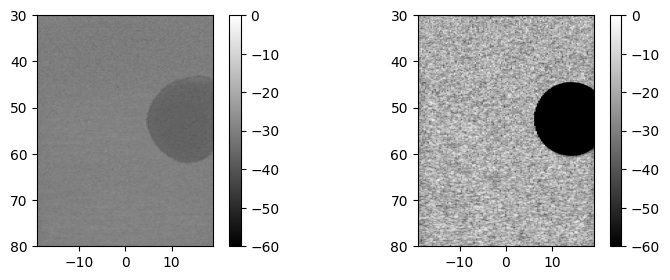

In [107]:
from matplotlib import pyplot as plt

file = testing_file_list[25]
bmode_output = np.load(gen_folder / file).squeeze()
bmode_output = (bmode_output + 1) * 30 - 60

target_folder = Path(r'F:\simulatedCystDataset\testing\target')
target = np.load(target_folder / file)
target = (target * 60) - 60

extent = [laterals[0] * 1e3, laterals[-1] * 1e3, depths[-1] * 1e3, depths[0] * 1e3]
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(bmode_output, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(target, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
plt.colorbar()
plt.show()


In [125]:
from metrics import compute_metrics
for id, file in enumerate(testing_file_list):
    bmode_output = np.load(gen_folder/file).squeeze()
    bmode_output = (bmode_output + 1) * 30 - 60
    cx = df.loc[id, "cx"]
    cz = df.loc[id, "cz"]
    r = df.loc[id, "r"]
    contrast, cnr, gcnr, snr = compute_metrics(cx, cz, r, bmode_output, grid)    
    df.loc[id, "contrast"] = contrast
    df.loc[id, "cnr"] = cnr
    df.loc[id, "snr"] = snr
    df.loc[id, "gcnr"] = gcnr
df.to_csv('diffusion_metrics.csv')
df.head()

C:\Users\smerino.C084288\AppData\Local\Temp\ipykernel_5480\2493267237.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9741622508093607' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.loc[id, "gcnr"] = gcnr


,id,r,cx,cz,c,contrast,cnr,snr,gcnr
0,14,0.008,-0.006,0.0550,1420.0,-6.793318,-3.467970,6.692020,0.974162
1,15,0.006,-0.008,0.0575,1570.0,-5.085077,-1.345184,3.685389,0.706385
2,16,0.006,-0.008,0.0475,1480.0,-3.902608,-0.919964,2.573589,0.514321
3,21,0.006,0.012,0.0600,1590.0,-5.899224,-2.224685,4.949989,0.890847
4,24,0.002,-0.004,0.0575,1420.0,-0.455523,-0.309782,7.672075,0.478086


In [126]:
das_folder = Path(r'F:\simulatedCystDataset\das_full')
for id, file in enumerate(testing_file_list):
    bmode = np.load(das_folder / file)
    bmode = (bmode * 60) - 60
    cx = df.loc[id, "cx"]
    cz = df.loc[id, "cz"]
    r = df.loc[id, "r"]
    contrast, cnr, gcnr, snr = compute_metrics(cx, cz, r, bmode, grid)
    df.loc[id, "contrast"] = contrast
    df.loc[id, "cnr"] = cnr
    df.loc[id, "snr"] = snr
    df.loc[id, "gcnr"] = gcnr
df.to_csv('das_metrics.csv')
df.head()


,id,r,cx,cz,c,contrast,cnr,snr,gcnr
0,14,0.008,-0.006,0.0550,1420.0,-30.688851,-1.390142,1.443542,0.848014
1,15,0.006,-0.008,0.0575,1570.0,-22.817605,-1.403920,1.540300,0.849718
2,16,0.006,-0.008,0.0475,1480.0,-27.121482,-1.467178,1.555569,0.838834
3,21,0.006,0.012,0.0600,1590.0,-22.864060,-1.362789,1.490916,0.850643
4,24,0.002,-0.004,0.0575,1420.0,-19.423373,-1.246181,1.432196,0.797116


# Comparing results

In [127]:
import seaborn as sns
import pandas as pd
df_das = pd.read_csv('das_metrics.csv')
df_diff = pd.read_csv('diffusion_metrics.csv')

In [128]:
df_das.head()

,Unnamed: 0,id,r,cx,cz,c,contrast,cnr,snr,gcnr
0,0,14,0.008,-0.006,0.0550,1420.0,-30.688851,-1.390142,1.443542,0.848014
1,1,15,0.006,-0.008,0.0575,1570.0,-22.817605,-1.403920,1.540300,0.849718
2,2,16,0.006,-0.008,0.0475,1480.0,-27.121482,-1.467178,1.555569,0.838834
3,3,21,0.006,0.012,0.0600,1590.0,-22.864060,-1.362789,1.490916,0.850643
4,4,24,0.002,-0.004,0.0575,1420.0,-19.423373,-1.246181,1.432196,0.797116


C:\Users\smerino.C084288\PycharmProjects\diffusion\venv\lib\site-packages\seaborn\relational.py:293: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data = grouped.apply(agg, other).reset_index()
C:\Users\smerino.C084288\PycharmProjects\diffusion\venv\lib\site-packages\seaborn\relational.py:293: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data = grouped.apply(agg, other).reset_index()


<Axes: xlabel='r', ylabel='contrast'>

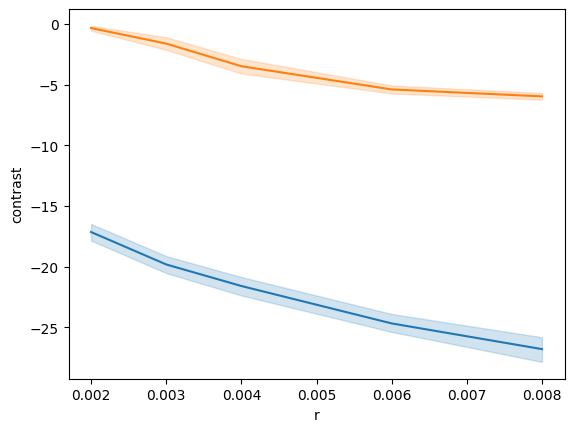

In [129]:
sns.lineplot(data=df_das, x='r', y='contrast')
sns.lineplot(data=df_diff, x='r', y='contrast')

C:\Users\smerino.C084288\PycharmProjects\diffusion\venv\lib\site-packages\seaborn\relational.py:293: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data = grouped.apply(agg, other).reset_index()
C:\Users\smerino.C084288\PycharmProjects\diffusion\venv\lib\site-packages\seaborn\relational.py:293: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data = grouped.apply(agg, other).reset_index()


<Axes: xlabel='r', ylabel='cnr'>

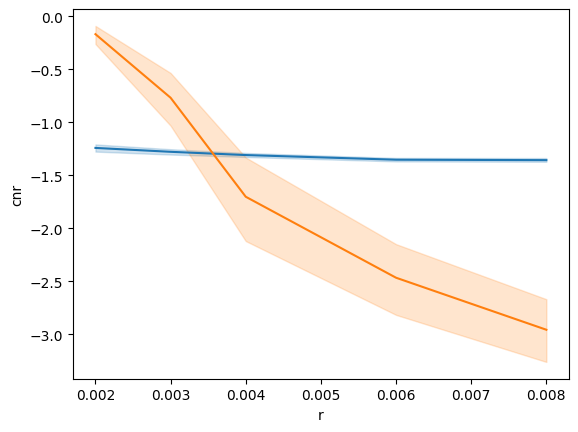

In [130]:
sns.lineplot(data=df_das, x='r', y='cnr')
sns.lineplot(data=df_diff, x='r', y='cnr')


C:\Users\smerino.C084288\PycharmProjects\diffusion\venv\lib\site-packages\seaborn\relational.py:293: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data = grouped.apply(agg, other).reset_index()
C:\Users\smerino.C084288\PycharmProjects\diffusion\venv\lib\site-packages\seaborn\relational.py:293: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data = grouped.apply(agg, other).reset_index()


<Axes: xlabel='r', ylabel='snr'>

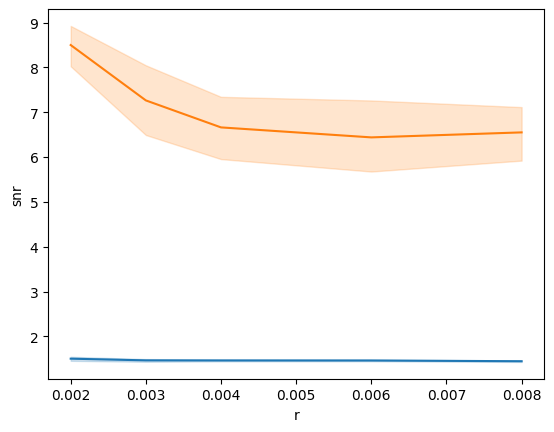

In [131]:
sns.lineplot(data=df_das, x='r', y='snr')
sns.lineplot(data=df_diff, x='r', y='snr')

C:\Users\smerino.C084288\PycharmProjects\diffusion\venv\lib\site-packages\seaborn\relational.py:293: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data = grouped.apply(agg, other).reset_index()
C:\Users\smerino.C084288\PycharmProjects\diffusion\venv\lib\site-packages\seaborn\relational.py:293: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data = grouped.apply(agg, other).reset_index()


<Axes: xlabel='r', ylabel='gcnr'>

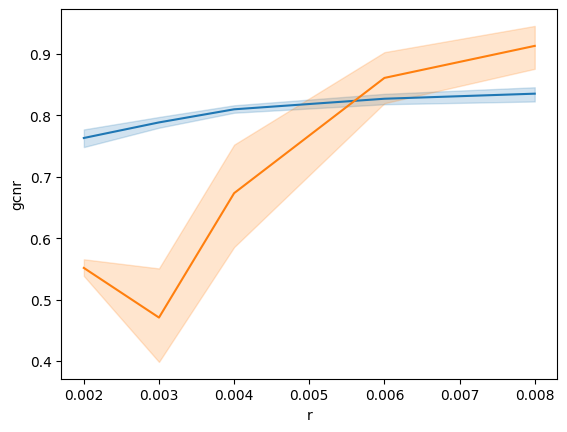

In [132]:
sns.lineplot(data=df_das, x='r', y='gcnr')
sns.lineplot(data=df_diff, x='r', y='gcnr')